In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy import *
from scipy.linalg import expm
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as mpatches
from brokenaxes import brokenaxes
from scipy import stats

In [5]:
# Range of time (unit: year)
t = arange(0, 650, 1)
time = arange(2000, 2000 + len(t))
# Range of age (unit: year)
age = arange(1, 1001)
# Concentration of CO2
X_at = [1715 * exp(0.0305 * ti) / (1715 + exp(0.0305 * ti) - 1) + 284 for ti in t]
# Global annual mean temperature
sigma = 4.5
Ts = [15 + (sigma / log(2)) * log(Xa / 285)
      for Xa in X_at]

############# Input #############
x = 0.65
Gamma_Ts = [42.7 + 1.68 * (T - 25) + 0.012 * (T - 25) ** 2 for T in Ts]
Beta_X_Ts = [(3 * x * Xa * Gamma) / ((x * Xa - Gamma) * (x * Xa + 2 * Gamma)) for Xa, Gamma in zip(X_at, Gamma_Ts)]
s0 = 300 # Input at initial time
# Input
S1 = [s0 * (1 + 2.14 * Beta * log(Xa / 285)) for Beta, Xa in zip(Beta_X_Ts, X_at)]
# Temperature scale
Var = [2 ** (0.1 * new - 1.5) for new in Ts]

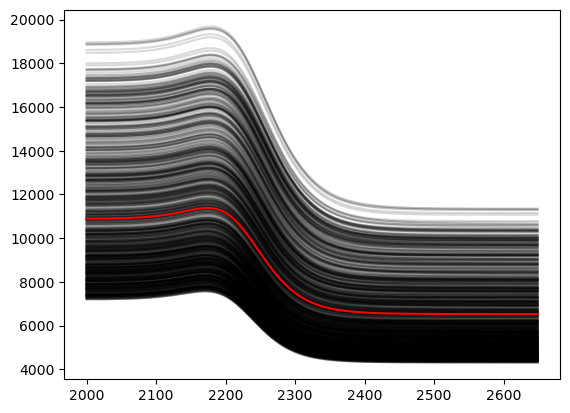

In [14]:
##################
# Linear model
##################
# range of the decay rate of fast, slow and passive carbon

# list_b11 = load('/Users/lifu/Downloads/age_paper_plot/para_b11.npy')
# list_b22 = load('/Users/lifu/Downloads/age_paper_plot/para_b22.npy')
# list_b33 = load('/Users/lifu/Downloads/age_paper_plot/para_b33.npy')

b_11 = linspace(-0.7 / 5 / 3, -0.7 / 5 * 3, 500)
b_22 = linspace(-0.23 / 5 / 3, -0.23 / 5 * 3, 500)
b_33 = linspace(-0.04 / 5 / 3, -0.04 / 5 * 3, 500)

number = 1000
list_P_LM_first = []  # Mean age at steady state in the linear model
list_P_LM_last = []  # Mean age in the last year in the linear model

list_P_LM_1_first = []
list_P_LM_1_last = []
list_P_LM_2_first = []
list_P_LM_2_last = []
list_P_LM_3_first = []
list_P_LM_3_last = []

# list_b11 = []
# list_b22 = []
# list_b33 = []
arr_LinearModel = array([[]] * 653)
arr_LinearModel_1 = array([[]] * 653)
arr_LinearModel_2 = array([[]] * 653)
arr_LinearModel_3 = array([[]] * 653)

arr_LinearModel_3d = empty(shape=(1, 650, 1000))
arr_LinearModel_3d_1 = empty(shape=(1, 650, 1000))
arr_LinearModel_3d_2 = empty(shape=(1, 650, 1000))
arr_LinearModel_3d_3 = empty(shape=(1, 650, 1000))

time = arange(2000, 2000 + len(t))

p0_a = array([]*650)

para_b11 = []
para_b22 = []
para_b33 = []

while number >= 1:
    # Transition matrix
    B_11 = random.choice(b_11)
    B_22 = random.choice(b_22)
    B_33 = random.choice(b_33)
    B_21 = 0.3525 / -0.7 * B_11
    B_31 = 0.0045 / -0.7 * B_11
    B_12 = 0.0103 / -0.23 * B_22
    B_32 = 0.001 / -0.23 * B_22
    B_23 = 0.02 / -0.04 * B_33
    B_13 = 0.02 / -0.04 * B_33

    # Soil carbon content at steady state
    C_ini_1 = 1.0 * S1[0] * (0.7 * B_12 * B_33 - 0.7 * B_13 * B_32 - 0.3 * B_22 * B_33 + 0.3 * B_23 * B_32) / (
                Var[0] * (
                    B_11 * B_22 * B_33 - B_11 * B_23 * B_32 - B_12 * B_21 * B_33 + B_12 * B_23 * B_31 + B_13 * B_21 * B_32 - B_13 * B_22 * B_31))
    C_ini_2 = -1.0 * S1[0] * (0.7 * B_11 * B_33 - 0.7 * B_13 * B_31 - 0.3 * B_21 * B_33 + 0.3 * B_23 * B_31) / (
                Var[0] * (
                    B_11 * B_22 * B_33 - B_11 * B_23 * B_32 - B_12 * B_21 * B_33 + B_12 * B_23 * B_31 + B_13 * B_21 * B_32 - B_13 * B_22 * B_31))
    C_ini_3 = S1[0] * (
                0.3 * B_31 * (B_11 * B_22 - B_12 * B_21) + (0.7 * B_11 - 0.3 * B_21) * (B_11 * B_32 - B_12 * B_31)) / (
                          Var[0] * ((B_11 * B_22 - B_12 * B_21) * (B_11 * B_33 - B_13 * B_31) - (
                              B_11 * B_23 - B_13 * B_21) * (B_11 * B_32 - B_12 * B_31)))
    # Soil carbon content at steady state less than 20000
    if 7200 < C_ini_1 + C_ini_2 + C_ini_3 < 20000:
        list_C1 = []
        list_C2 = []
        list_C3 = []
        for V, S11 in zip(Var, S1):
            del_C1 = B_11 * V * C_ini_1 + B_12 * V * C_ini_2 + B_13 * V * C_ini_3 + 3 / 10 * S11
            del_C2 = B_21 * V * C_ini_1 + B_22 * V * C_ini_2 + B_23 * V * C_ini_3 + 7 / 10 * S11
            del_C3 = B_31 * V * C_ini_1 + B_32 * V * C_ini_2 + B_33 * V * C_ini_3
            C_ini_1 = C_ini_1 + del_C1
            C_ini_2 = C_ini_2 + del_C2
            C_ini_3 = C_ini_3 + del_C3
            list_C1.append(C_ini_1)
            list_C2.append(C_ini_2)
            list_C3.append(C_ini_3)
        arr_tem = array(list_C1) + array(list_C2) + array(list_C3)
        arr_tem_1 = array(list_C1)
        arr_tem_2 = array(list_C2)
        arr_tem_3 = array(list_C3)
        
        if arr_tem[649] - arr_tem[0] < -1000:
            plt.plot(arange(2000, 2650), array(list_C1) + array(list_C2) + array(list_C3), color='k', alpha=0.15)
            arr_tem2 = insert(arr_tem, 0, [B_11, B_22, B_33])
            arr_tem2_1 = insert(arr_tem_1, 0, [B_11, B_22, B_33])
            arr_tem2_2 = insert(arr_tem_2, 0, [B_11, B_22, B_33])
            arr_tem2_3 = insert(arr_tem_3, 0, [B_11, B_22, B_33])
            
            # list_b11.append(B_11)
            # list_b22.append(B_22)
            # list_b33.append(B_33)
            
            arr_LinearModel = column_stack((arr_LinearModel, arr_tem2))
            arr_LinearModel_1 = column_stack((arr_LinearModel_1, arr_tem2_1))
            arr_LinearModel_2 = column_stack((arr_LinearModel_2, arr_tem2_2))
            arr_LinearModel_3 = column_stack((arr_LinearModel_3, arr_tem2_3))

            
            para_b11.append(B_11)
            para_b22.append(B_22)
            para_b33.append(B_33)
            number = number - 1
    continue
LinearModel_mean_Cs = average(arr_LinearModel.T, axis=0)
plt.plot(arange(2000, 2650), LinearModel_mean_Cs[3:], c='r')



#             ######################################## Compute age distribution
#             # Transition matrix at steady state
#             B_t = mat([
#                 [B_11 * Var[0], B_12 * Var[0], B_13 * Var[0]],
#                 [B_21 * Var[0], B_22 * Var[0], B_23 * Var[0]],
#                 [B_31 * Var[0], B_32 * Var[0], B_33 * Var[0]]])
#             # Input at steady state
#             S_t = mat([[3 / 10 * S1[0]],
#                        [7 / 10 * S1[0]],
#                        [0]])
#             # age mass distribution at steady state
#             p0_a = [expm(A * B_t) * S_t for A in age]
            


#             soc1_dataframe = pd.DataFrame(columns=['year', 'soc7'])
#             Input_1 = [3 / 10 * S1[yr - 2000] for yr in time]
#             pa_pre1 = p0_a.copy()
#             pa_pre1 = hstack(pa_pre1)
#             pa_pre1_1 = pa_pre1[0, :1000]
#             ##########################################################################
#             soc2_dataframe = pd.DataFrame(columns=['year', 'soc8'])
#             Input_2 = [7 / 10 * S1[yr - 2000] for yr in time]
#             pa_pre2 = p0_a.copy()
#             pa_pre2 = hstack(pa_pre2)
#             pa_pre1_2 = pa_pre2[1, :1000]
#             ##########################################################################
#             soc3_dataframe = pd.DataFrame(columns=['year', 'soc9'])
#             Input_3 = [0 * S1[yr - 2000] for yr in time]
#             pa_pre3 = p0_a.copy()
#             pa_pre3 = hstack(pa_pre3)
#             pa_pre1_3 = pa_pre3[2, :1000]
            

#             age_density_1 = []
#             age_density_2 = []
#             age_density_3 = []

#             for yr in time:
#                 soc1_dataframe.loc[len(soc1_dataframe)] = [yr, sum(pa_pre1_1[:1000])]
#                 soc2_dataframe.loc[len(soc2_dataframe)] = [yr, sum(pa_pre1_2[:1000])]
#                 soc3_dataframe.loc[len(soc3_dataframe)] = [yr, sum(pa_pre1_3[:1000])]
#                 pa_pre1_1 = [Input_1[yr - 2000]] + list(array(pa_pre1_1[:len(age)]).reshape(len(age), ))
#                 pa_pre1_2 = [Input_2[yr - 2000]] + list(array(pa_pre1_2[:len(age)]).reshape(len(age), ))
#                 pa_pre1_3 = [Input_3[yr - 2000]] + list(array(pa_pre1_3[:len(age)]).reshape(len(age), ))

#                 pa_tmp_1 = array(pa_pre1_1[:1000]) + array(pa_pre1_1[:1000]) * B_11 * Var[yr - 2000] + \
#                            B_12 * Var[yr - 2000] * array(pa_pre1_2[:1000]) + B_13 * Var[yr - 2000] * array(pa_pre1_3[:1000])
#                 pa_tmp_2 = array(pa_pre1_2[:1000]) + array(pa_pre1_2[:1000]) * B_22 * Var[yr - 2000] + \
#                            B_21 * Var[yr - 2000] * array(pa_pre1_1[:1000]) + B_23 * Var[yr - 2000] * array(pa_pre1_3[:1000])
#                 pa_tmp_3 = array(pa_pre1_3[:1000]) + array(pa_pre1_3[:1000]) * B_33 * Var[yr - 2000] + \
#                            B_31 * Var[yr - 2000] * array(pa_pre1_1[:1000]) + B_32 * Var[yr - 2000] * array(pa_pre1_2[:1000])

#                 pa_tmp_1 = pa_tmp_1.reshape(1000, )
#                 pa_tmp_2 = pa_tmp_2.reshape(1000, )
#                 pa_tmp_3 = pa_tmp_3.reshape(1000, )

#                 pa_pre1_1 = pa_tmp_1.copy()
#                 pa_pre1_2 = pa_tmp_2.copy()
#                 pa_pre1_3 = pa_tmp_3.copy()

#                 age_density_1 = age_density_1 + list(pa_tmp_1[:1000])
#                 age_density_2 = age_density_2 + list(pa_tmp_2[:1000])
#                 age_density_3 = age_density_3 + list(pa_tmp_3[:1000])

#             age_density_1 = array(age_density_1).reshape(len(time), len(age))
#             age_density_2 = array(age_density_2).reshape(len(time), len(age))
#             age_density_3 = array(age_density_3).reshape(len(time), len(age))
#             all_density = age_density_1 + age_density_2 + age_density_3

#             # Compute age probability distribution
#             age_density_carbon = all_density / all_density.sum(axis=1)[:, None]            

#             pa_LinearModel_first = []
#             for i in range(1, 1001):
#                 pa_tem = i * age_density_carbon[0, i - 1]
#                 pa_LinearModel_first.append(pa_tem)
#             mean_tem = sum(pa_LinearModel_first)
#             pa_LinearModel_last = []
#             for i in range(1, 1001):
#                 pa_tem2 = i * age_density_carbon[649, i - 1]
#                 pa_LinearModel_last.append(pa_tem2)
#             mean_tem2 = sum(pa_LinearModel_last)

#             list_P_LM_first.append(mean_tem)
#             list_P_LM_last.append(mean_tem2)
            
#             ############ 1
#             age_density_1_carbon = age_density_1 / age_density_1.sum(axis=1)[:, None]


#             pa_LinearModel_first = []
#             for i in range(1, 1001):
#                 pa_tem = i * age_density_1_carbon[0, i - 1]
#                 pa_LinearModel_first.append(pa_tem)
#             mean_tem = sum(pa_LinearModel_first)
#             pa_LinearModel_last = []
#             for i in range(1, 1001):
#                 pa_tem2 = i * age_density_1_carbon[649, i - 1]
#                 pa_LinearModel_last.append(pa_tem2)
#             mean_tem2 = sum(pa_LinearModel_last)

#             list_P_LM_1_first.append(mean_tem)
#             list_P_LM_1_last.append(mean_tem2)

#             ########### 2
#             age_density_2_carbon = age_density_2 / age_density_2.sum(axis=1)[:, None]

#             pa_LinearModel_first = []
#             for i in range(1, 1001):
#                 pa_tem = i * age_density_carbon[0, i - 1]
#                 pa_LinearModel_first.append(pa_tem)
#             mean_tem = sum(pa_LinearModel_first)
#             pa_LinearModel_last = []
#             for i in range(1, 1001):
#                 pa_tem2 = i * age_density_carbon[649, i - 1]
#                 pa_LinearModel_last.append(pa_tem2)
#             mean_tem2 = sum(pa_LinearModel_last)

#             list_P_LM_2_first.append(mean_tem)
#             list_P_LM_2_last.append(mean_tem2)

#             ########### 3
#             age_density_3_carbon = age_density_3 / age_density_3.sum(axis=1)[:, None]

#             pa_LinearModel_first = []
#             for i in range(1, 1001):
#                 pa_tem = i * age_density_carbon[0, i - 1]
#                 pa_LinearModel_first.append(pa_tem)
#             mean_tem = sum(pa_LinearModel_first)
#             pa_LinearModel_last = []
#             for i in range(1, 1001):
#                 pa_tem2 = i * age_density_carbon[649, i - 1]
#                 pa_LinearModel_last.append(pa_tem2)
#             mean_tem2 = sum(pa_LinearModel_last)

#             list_P_LM_3_first.append(mean_tem)
#             list_P_LM_3_last.append(mean_tem2)


#             age_density_carbon_tem = age_density_carbon[newaxis, :]
#             arr_LinearModel_3d = vstack((arr_LinearModel_3d, age_density_carbon_tem))

#             age_density_carbon_tem_1 = age_density_1_carbon[newaxis, :]
#             arr_LinearModel_3d_1 = vstack((arr_LinearModel_3d_1, age_density_carbon_tem_1))

#             age_density_carbon_tem_2 = age_density_2_carbon[newaxis, :]
#             arr_LinearModel_3d_2 = vstack((arr_LinearModel_3d_2, age_density_carbon_tem_2))

#             age_density_carbon_tem_3 = age_density_3_carbon[newaxis, :]
#             arr_LinearModel_3d_3 = vstack((arr_LinearModel_3d_3, age_density_carbon_tem_3))

#             number = number - 1
            
#     continue


# arr_LinearModel = arr_LinearModel.T
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_Cs_1000', arr_LinearModel)
# arr_LinearModel_1 = arr_LinearModel_1.T
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_Cs_1_1000', arr_LinearModel_1)
# arr_LinearModel_2 = arr_LinearModel_2.T
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_Cs_2_1000', arr_LinearModel_2)
# arr_LinearModel_3 = arr_LinearModel_3.T
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_Cs_3_1000', arr_LinearModel_3)



# arr_LinearModel_3d = delete(arr_LinearModel_3d, 0, axis=0)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_3d_1000', arr_LinearModel_3d)
# arr_LinearModel_3d_1 = delete(arr_LinearModel_3d_1, 0, axis=0)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_3d_1000_1', arr_LinearModel_3d_1)
# arr_LinearModel_3d_2 = delete(arr_LinearModel_3d_2, 0, axis=0)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_3d_1000_2', arr_LinearModel_3d_2)
# arr_LinearModel_3d_3 = delete(arr_LinearModel_3d_3, 0, axis=0)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_3d_1000_3', arr_LinearModel_3d_3)



# list_P_LM_first = array(list_P_LM_first)
# list_P_LM_last = array(list_P_LM_last)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_ma_f_1000', list_P_LM_first)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_ma_l_1000', list_P_LM_last)

# list_P_LM_1_first = array(list_P_LM_1_first)
# list_P_LM_1_last = array(list_P_LM_1_last)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_ma_f_1_1000', list_P_LM_1_first)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_ma_l_1_1000', list_P_LM_1_last)

# list_P_LM_2_first = array(list_P_LM_2_first)
# list_P_LM_2_last = array(list_P_LM_2_last)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_ma_f_2_1000', list_P_LM_2_first)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_ma_l_2_1000', list_P_LM_2_last)

# list_P_LM_3_first = array(list_P_LM_3_first)
# list_P_LM_3_last = array(list_P_LM_3_last)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_ma_f_3_1000', list_P_LM_3_first)
# save('/Users/lifu/Downloads/age_paper_plot/arr_LM_ma_l_3_1000', list_P_LM_3_last)

# save('/Users/lifu/Downloads/age_paper_plot/para_b11', para_b11)
# save('/Users/lifu/Downloads/age_paper_plot/para_b22', para_b22)
# save('/Users/lifu/Downloads/age_paper_plot/para_b33', para_b33)
